TODO

[github](https://github.com/abhishekkrthakur/commonlit-pairwise-model)

In [1]:
from IPython.display import clear_output, Image
!pip install transformers
clear_output()

In [2]:
import os
import re
import torch
import itertools
import transformers
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import random
from torch import nn, optim
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import model_selection
from torch.optim.lr_scheduler import LambdaLR

"""
получения информации о запущенных процессах
и использовании системы (ЦП, память, диски, сеть, датчики) в Python.
"""
import psutil

path_tr = '/content/drive/MyDrive/CommonLit/input/train.csv'
path_test = '/content/drive/MyDrive/CommonLit/input/test.csv'
path_sub = '/content/drive/MyDrive/CommonLit/input/sample_submission.csv'

SEED =13
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


def create_folds(data, num_splits):
    data["kfold"] = -1
    data = data.sample(frac=1).reset_index(drop=True)
    num_bins = int(np.floor(1 + np.log2(len(data))))
    data.loc[:, "bins"] = pd.cut(
        data["target"], bins=num_bins, labels=False
    )
    kf = model_selection.StratifiedKFold(n_splits=num_splits)
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
        data.loc[v_, 'kfold'] = f
    data = data.drop("bins", axis=1)
    return data


class CommonlitDataset:
    def __init__(self, excerpts, target_dict, error_dict, tokenizer, max_len, num_samples=None):
        self.excerpts = excerpts
        self.target_dict = target_dict
        self.error_dict = error_dict
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.num_samples = num_samples
        self.count = 0

    def __len__(self):
        if self.num_samples is None:
            return len(self.excerpts)
        return self.num_samples

    def __getitem__(self, item):
        if self.num_samples is not None:
            self.count += 1
            # 5000 / 2
            if self.count >= self.num_samples / psutil.cpu_count():
                self.count = 0
                random.shuffle(self.excerpts)

        """
        we have pair itertools.combinations
        (txt1, txt2)        
        """
        text1 = str(self.excerpts[item][1])
        text2 = str(self.excerpts[item][0])
        """
        dict key(txt) : values(target)        
        """
        target = [
            self.target_dict[text2],
            self.target_dict[text1],
        ]

        inputs1 = self.tokenizer(text1, max_length=self.max_len, padding="max_length", truncation=True)
        inputs2 = self.tokenizer(text2, max_length=self.max_len, padding="max_length", truncation=True)

        ids1 = inputs1["input_ids"]
        mask1 = inputs1["attention_mask"]

        ids2 = inputs2["input_ids"]
        mask2 = inputs2["attention_mask"]

        return {
            "ids1": torch.tensor(ids1, dtype=torch.long),
            "mask1": torch.tensor(mask1, dtype=torch.long),
            "ids2": torch.tensor(ids2, dtype=torch.long),
            "mask2": torch.tensor(mask2, dtype=torch.long),
            "targets": torch.tensor(target, dtype=torch.float),
        }

In [ ]:
lr = 1
epochs = 200
max_len = 256
batch_size = 16
num_samples = 5000
accumulation_steps = 1

seed_everything(42)
df = pd.read_csv(path_tr)
df = create_folds(df, num_splits=5)
"""
base string is excerpt where target is 0 in the dataframe
df.loc[df.target == 0, "excerpt"]
>> 
  The sun was shining in a cloudless sky, and no...
"""
base_string = df.loc[df.target == 0, "excerpt"].values[0]
# create dictionary out of excerpt and target columns from dataframe
# text: value
target_dict = dict(zip(df.excerpt.values.tolist(), df.target.values.tolist()))
df_train = df[df.kfold != 0].reset_index(drop=True)
df_valid = df[df.kfold == 0].reset_index(drop=True)

In [ ]:
"""
train_pair:
    ('The soil most suitable for the full development t or ... large yellow flowers.',
    'The journey from Burnet to Hillsover was a very . The ... in fact, notice it.'),
    ('The soil most suitable for the full developmentot or ... large yellow flowers.',
    'One of the first steps of the scientific method stand ...  dark matter (CDM)."'),
    ('The soil most suitable for the full developmentot or ... large yellow flowers.',
    'Bhabhloo was a very, very naughty bear, loved by ...)
    ('The soil most suitable for the full development t or ... large yellow flowers.',
    'In 1832 Dr. James Mease, ... )
valid_pair:
    we use for each base string to each valid    
        ('The sun was shining in  again. ...',
        "Alice looked at the juriness?' the ... ng whatever,' said Alice."),
        ('The sun was shining in  again. ...',
        'Artificial intelligence ...)
"""
training_pairs = list(itertools.combinations(df_train.excerpt.values.tolist(), 2))
# randomize training_pairs
random.shuffle(training_pairs)
validation_pairs = [(base_string, k) for k in df_valid.excerpt.values.tolist()]
tokenizer = transformers.AutoTokenizer.from_pretrained('microsoft/deberta-large')
len(target_dict), len(training_pairs), len(validation_pairs)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

(2834, 2568511, 567)

In [ ]:
train_dataset = CommonlitDataset(
    excerpts=training_pairs,
    target_dict=target_dict,
    error_dict = None,
    tokenizer=tokenizer,
    max_len=max_len,
    num_samples=num_samples, #default values
)

In [ ]:
train_dataset[0]

{'ids1': tensor([    1, 46100,  2239,    16,    10,  2849,  1399,     9,  3034,  2866,
            14, 12236,    31,     5,   892,     9,  6184,  4972,     8, 38163,
          2239,  6680,    11,  7350,  2316,     4,    96, 23342,     6,  9411,
          9581,  6533,  3563,  2239,    25,    10,    22, 27780,     9,   892,
            14,  2029,  7796,     5,  1460,     7,  1532,   396,   145, 16369,
         30825,   845, 14969,  2239, 17384,     5,   892,     8,  1663,     9,
         16964,    14,    64,  1532,    31,     8,   146, 12535,    15,   414,
             4,  5598, 16964,  4303,    30,   745,    10,  1421,    31,  1246,
         16584,    11,   645,     7,   146,   414,    12,  9756, 12535,    50,
          2390,     6,    35,   176,  1195,    87,   511, 14657, 25156,   586,
          9223,     4, 50118, 46100,  2239,    16,  3615,  1330,     7,    36,
           463,   747, 31669,  7527,    19,    43, 38163,  6732,   131,    10,
          8882,    61,    67,  7235,    11, 

In [ ]:
def custom_scheduler(optimizer, steps_per_epoch, lr_min, lr_max):
    def lr_lambda(current_step):
        current_step = current_step % steps_per_epoch
        if current_step < steps_per_epoch / 2:
            y = ((lr_max - lr_min) / (steps_per_epoch / 2)) * current_step + lr_min
        else:
            y = (-1.0 * (lr_max - lr_min) / (steps_per_epoch / 2)) * current_step + lr_max + (lr_max - lr_min)
        return y

    return LambdaLR(optimizer, lr_lambda, last_epoch=-1)


class AttentionHead(nn.Module):
    """take model out, attention on max prob
    """
    def __init__(self, in_size: int = 768, hidden_size: int = 512) -> None:
        super().__init__()
        self.W = nn.Linear(in_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, features):
        """
        features --
            attention
                after transformer
                a = (768, 512).tanh
                make score (512, 1)(a)
                weight softmax(score), range [0,1] and sum to 1(find max prob)
        attention weight * features
        """
        att = torch.tanh(self.W(features))
        score = self.V(att)
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)
        output = self.dropout(context_vector)
        return output


class CommonlitModel(tez.Model):
    def __init__(self, model_name, num_train_steps, steps_per_epoch, learning_rate):
        super().__init__()
        self.learning_rate = learning_rate
        self.steps_per_epoch = steps_per_epoch
        self.model_name = model_name
        self.num_train_steps = num_train_steps # not used???
        self.step_scheduler_after = "batch"
        hidden_dropout_prob: float = 0.0
        layer_norm_eps: float = 1e-7
        config = transformers.AutoConfig.from_pretrained(model_name)
        """
        default param model:
            "hidden_dropout_prob": 0.1,
            "layer_norm_eps": 1e-07,        
        """

        config.update(
            {
                "output_hidden_states": True,
                "hidden_dropout_prob": hidden_dropout_prob,
                "layer_norm_eps": layer_norm_eps,
            }
        )
        self.transformer = transformers.AutoModel.from_pretrained(model_name, config=config)
        self.attention = AttentionHead(in_size=config.hidden_size, hidden_size=config.hidden_size)
        """
        two outs
        """
        self.regressor = nn.Linear(config.hidden_size * 2, 2)

    def fetch_optimizer(self):
        """ not change lr        
        """
        param_optimizer = list(self.named_parameters())
        no_decay = ["bias", "LayerNorm.bias"]
        optimizer_parameters = [
            {
                "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                "weight_decay": 0.001,
            },
            {
                "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        opt = AdamW(optimizer_parameters, lr=self.learning_rate)
        return opt

    def fetch_scheduler(self):
        sch = custom_scheduler(
            self.optimizer,
            self.steps_per_epoch,
            1e-6,
            1.5e-5,
        )
        return sch

    def loss(self, outputs, targets):
        return torch.sqrt(nn.MSELoss()(outputs, targets))

    def monitor_metrics(self, outputs, targets):
        outputs = outputs.cpu().detach().numpy()[:, 1].ravel()
        targets = targets.cpu().detach().numpy()[:, 1].ravel()
        mse = metrics.mean_squared_error(targets, outputs)
        rmse = np.sqrt(mse)
        return {"rmse": rmse, "mse": mse}

    def forward(self, ids1, mask1, ids2, mask2, targets=None):
        """
        transformer == transformers.AutoModel 'microsoft/deberta-large'
        two outs
        concat
        regressor
        
        """
        output1 = self.transformer(ids1, mask1)
        output2 = self.transformer(ids2, mask2)
        output1 = self.attention(output1.last_hidden_state)
        output2 = self.attention(output2.last_hidden_state)
        output = torch.cat((output1, output2), dim=1)
        output = self.regressor(output)
        # output = self.regressor(output.pooler_output)
        loss = self.loss(output, targets)
        acc = self.monitor_metrics(output, targets)
        return output, loss, acc

In [ ]:
# not used???
# if lr == 1:
#     n_train_steps = 5000 / batch_size * 20)
# else:
#     n_train_steps = 5000 / batch_size * epochs)

In [ ]:
model = transformers.AutoModel.from_pretrained('microsoft/deberta-large')
optimizer = transformers.AdamW(model.parameters())

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


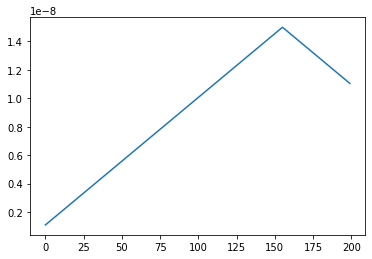

In [27]:
def custom_scheduler(optimizer, steps_per_epoch, lr_min, lr_max):
    def lr_lambda(current_step):
        """ current_step == epoch  
            steps_per_epoch == 5000/16 (312)

        if current_step < steps_per_epoch / 2:
            <160 epoch
        else
            >160 epoch
        """        
        current_step = current_step % steps_per_epoch        
        if current_step < steps_per_epoch / 2:           
            y = ((lr_max - lr_min) / (steps_per_epoch / 2)) * current_step + lr_min
        else:
            y = (-1.0 * (lr_max - lr_min) / (steps_per_epoch / 2)) * current_step + lr_max + (lr_max - lr_min)
        return y
    return LambdaLR(optimizer, lr_lambda, last_epoch=-1)


cs = custom_scheduler(
    optimizer,
    int(5000/16), # 312
    1e-6,
    1.5e-5,
)
tmp = []
for epoch in range(200):
    cs.step()
    tmp.append(optimizer.param_groups[0]['lr'])

plt.plot(tmp)

In [ ]:
https://github.com/abhishekkrthakur/tez
todo check conde lib tez